# Life Expectancy Prediction
- Data set is imputed using KNN and Random Forest. <br>
*Imputed values may not be accurate and are used for the sake of Neural Network Prediction*
- I have included step by step explaination for better understanding.

#### 1. Importing Libraries
- pandas: For data manipulation and analysis
- numpy: For numerical operations
- matplotlib.pyplot: For data visualization
- sklearn: For building and training ML models and imputers
- tensorflow: For building and training the neural network model

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import tensorflow as tf

#### 2. Load the data set and set variables
- Load the life expectancy dataset from a CSV file into a pandas DataFrame.
- Replace all missing values in the DataFrame with 0 for finding out scale of missing values.

In [2]:
# Setting path to input files
file = "/Users/anish/Documents/Programming/Project_3_Life_Expectancy/Life_Expectancy_Data.csv"

# Creating dataframes
data = pd.read_csv(file)
df = pd.DataFrame(data)

# Replace all null values with 0
df.fillna(0, inplace=True)

#### 3. Pre Processing data and filling all missing values
- Define columns to exclude from numeric processing
- Identify numeric columns for further processing

In [3]:
# List for non numeric & numeric columns
exclude_cols = ['Country', 'Year', 'Status']
numeric_cols = df.columns.difference(exclude_cols)

#### 4. Imputing missing values for countries *without full* missing columns
- Define a function to check if all values in a column are zero or not
- Initialize the KNN Imputer
- Impute missing data for each country using KNN, replacing zero values with NaN for imputation and then back to 0 if necessary
- Concatenate the imputed data back into a single DataFrame

In [4]:
# Imputing missing data for columns with less than 5 missing values using knn

# Function to check if all values in a column are 0 for a specific country
def all_zeros(col):
    return (col == 0).all()

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation for each country
imputed_data = []
for country in df['Country'].unique():
    country_data = df[df['Country'] == country]
    zero_cols = [col for col in numeric_cols if all_zeros(country_data[col])]
    
    # Columns to impute
    cols_to_impute = [col for col in numeric_cols if col not in zero_cols]
    
    # Create a copy of the country data for imputation
    country_data_impute = country_data.copy()
    
    # Replace 0s with NaNs for the imputation
    country_data_impute[cols_to_impute] = country_data_impute[cols_to_impute].replace(0, np.nan)
    
    # Impute only if there are columns to impute
    if len(cols_to_impute) > 0:
        country_data_impute[cols_to_impute] = imputer.fit_transform(country_data_impute[cols_to_impute])
    
    # Replace NaNs back to 0s where they were originally 0s
    country_data_impute[cols_to_impute] = country_data_impute[cols_to_impute].fillna(0)
    
    imputed_data.append(country_data_impute)

# Concatenate all the imputed data back into a single DataFrame
df_imputed = pd.concat(imputed_data, ignore_index=True)

#### 5. Imputing columns for countries with columns missing
- Define functions for KNN and Random Forest imputation
- Apply KNN imputation to initially fill missing values
- Apply Random Forest imputation for more accurate results

In [5]:
# Imputing remaining missing values

# Initializing df
df = pd.DataFrame(df_imputed)

# Function to perform KNN imputation again
def knn_impute(df, cols_to_impute, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
    return df

# Function to perform random forest imputation
def random_forest_impute(df, cols_to_impute):
    for col in cols_to_impute:
        # Create a mask for missing values
        mask = df[col] == 0
        # Only perform imputation if there are missing values
        if mask.sum() == 0:
            continue     
        # Define features and target
        X_train = df.loc[~mask, df.columns.difference([col])]
        y_train = df.loc[~mask, col]
        X_test = df.loc[mask, df.columns.difference([col])]
        
        # Train the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict the missing values
        df.loc[mask, col] = model.predict(X_test)
    return df

# Get the list of numeric columns
numeric_cols = df.columns[3:]

# Replace 0s with NaNs for the purpose of imputation
df[numeric_cols] = df[numeric_cols].replace(0, np.nan)

# Step 1: Apply KNN imputation to fill initial missing values
df = knn_impute(df, numeric_cols)

# Replace NaNs back to 0s if imputation wasn't possible (though this should be rare with KNN)
df[numeric_cols] = df[numeric_cols].fillna(0)

# Step 2: Apply Random Forest imputation for more accurate results
df = random_forest_impute(df, numeric_cols)

# Replace any remaining NaNs with 0
df[numeric_cols] = df[numeric_cols].fillna(0)

#### 6. Creating TensorFlow to Predict & Analyze future life expectancy
- Define features and target for the model
- Split the data into training and testing sets
- Normalize the features
- Build, compile, and train a TensorFlow neural network model
- Evaluate the model and print the RMSE on test data
- Predict life expectancy on test data
- Create a DataFrame to store actual and predicted values
- Group results by year and plot the actual vs predicted life expectancy
- Analyze results

Epoch 1/100


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_17715/3982597677.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Year'] = df['Year']
2024-06-13 18:54:58.665138: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


59/59 [==============================] - 0s 2ms/step - loss: 4470.5840 - mean_squared_error: 4470.5840 - val_loss: 3991.8608 - val_mean_squared_error: 3991.8608
Epoch 2/100
59/59 [==============================] - 0s 606us/step - loss: 2899.2380 - mean_squared_error: 2899.2380 - val_loss: 1650.9438 - val_mean_squared_error: 1650.9438
Epoch 3/100
59/59 [==============================] - 0s 590us/step - loss: 956.9357 - mean_squared_error: 956.9357 - val_loss: 485.1234 - val_mean_squared_error: 485.1234
Epoch 4/100
59/59 [==============================] - 0s 589us/step - loss: 454.5302 - mean_squared_error: 454.5302 - val_loss: 262.6834 - val_mean_squared_error: 262.6834
Epoch 5/100
59/59 [==============================] - 0s 589us/step - loss: 323.9978 - mean_squared_error: 323.9978 - val_loss: 195.4883 - val_mean_squared_error: 195.4883
Epoch 6/100
59/59 [==============================] - 0s 590us/step - loss: 274.2476 - mean_squared_error: 274.2476 - val_loss: 157.7220 - val_mean_squa

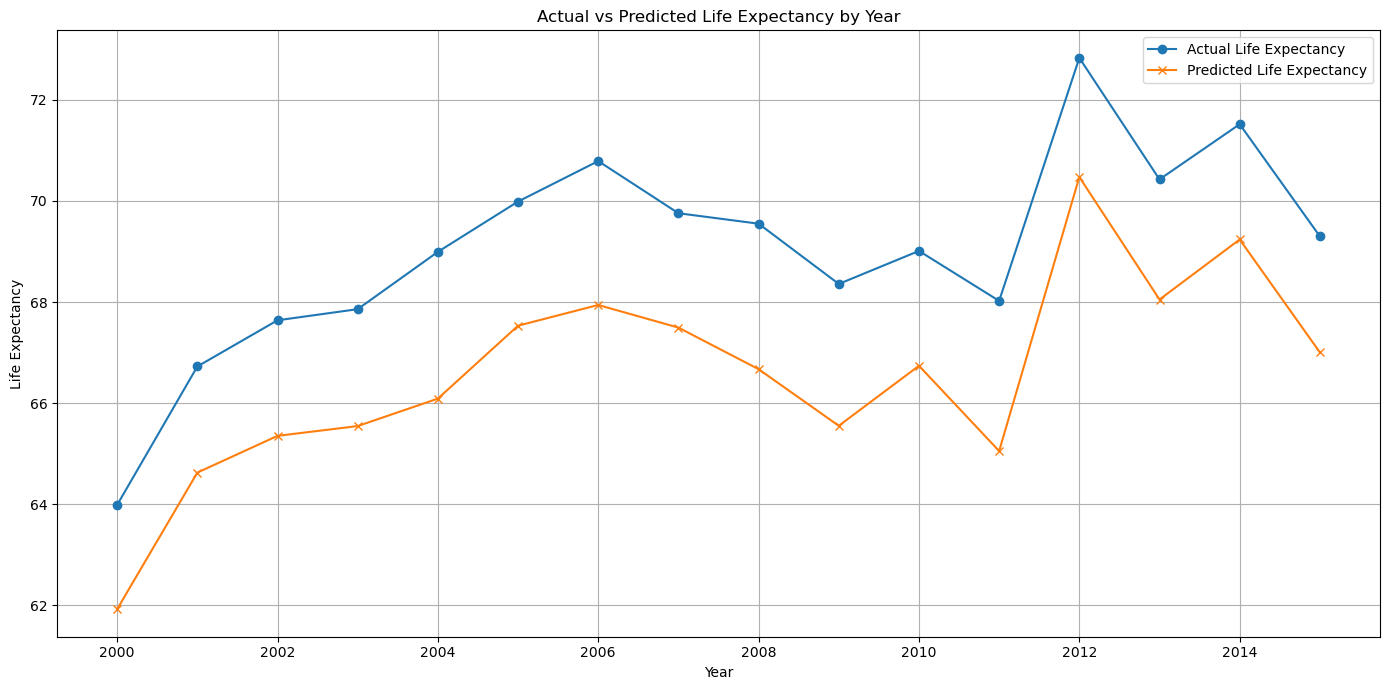

In [6]:
# Define features and target
features = df.columns[3:]  # All columns after 'Status'
target = 'Life expectancy '

X = df[features]
y = df[target]

# Include 'Year' in the features for plotting
X['Year'] = df['Year']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Year' for plotting
X_test_years = X_test['Year']
X_train = X_train.drop(columns='Year')
X_test = X_test.drop(columns='Year')

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Evaluate the model
mse, _ = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Test Data: {rmse:.4f}')

# Predict and analyze
y_pred = model.predict(X_test)

# Prepare data for plotting
predictions = y_pred.flatten()
y_test = y_test.values.flatten()
results_df = pd.DataFrame({'Year': X_test_years, 'Actual Life Expectancy': y_test, 'Predicted Life Expectancy': predictions})

# Group by year and average life expectancy
grouped_results = results_df.groupby('Year').mean().reset_index()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Year'], grouped_results['Actual Life Expectancy'], label='Actual Life Expectancy', marker='o')
plt.plot(grouped_results['Year'], grouped_results['Predicted Life Expectancy'], label='Predicted Life Expectancy', marker='x')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Actual vs Predicted Life Expectancy by Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 7. Predicting future life expectancy for the next year
- Predict life expectancy for the next year
- Create a future DataFrame to store predictions
- Preprocess future data and predict future life expectancy
- Save predicted life expectancy with future year under 'life expectancy' column
- Clear other columns for future data *(not predicted)*
- Concatenate original and future DataFrames, sort, and save the result to a CSV file

In [7]:
# Predicting future life expectancy for the next year
future_years = [df['Year'].max() + 1]

# Create a future DataFrame for predictions using list comprehension
future_data = [df[df['Country'] == country].iloc[-1].copy() for country in df['Country'].unique() for year in future_years]

# Update the year in each row of the future DataFrame
for data in future_data:
    data['Year'] = future_years[0]

future_df = pd.DataFrame(future_data)

# Preprocess future data
future_df_features = future_df[features]
future_df_year = future_df[['Year']]
# future_df_features = future_df_features.drop(columns='Year')

# Normalize future data
future_df_features_scaled = scaler.transform(future_df_features)

# Predict future life expectancy
future_predictions = model.predict(future_df_features_scaled)

# Add predictions to future_df
future_df['Predicted Life Expectancy'] = future_predictions

future_df['Life expectancy '], future_df['Predicted Life Expectancy'] = future_df['Predicted Life Expectancy'], future_df['Life expectancy ']

# Define the columns to clear
cols_to_replace = future_df.columns[4:]

# Replace values with NaN
future_df[cols_to_replace] = np.nan

future_df.drop(columns=['Predicted Life Expectancy'], inplace=True)

# Vertically concatenate the original df and future_df
result = pd.concat([df, future_df], ignore_index=True)

# Sort new_df by 'Country' in ascending order and 'Year' in descending order in place
result.sort_values(by=['Country', 'Year'], ascending=[True, False], inplace=True)

7/7 [==============================] - 0s 512us/step


In [11]:
# # Save the final dataframe
output_path = '/Users/anish/Documents/Programming/Project_3_Life_Expectancy/predicted_life_expectancy.csv'

result.to_csv(output_path, index=False)